导入库和数据

In [46]:
import torch
import torch.nn as nn
import csv
import sys
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p

import numpy as np
import seaborn as sns

import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler, RobustScaler ,OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin, clone

import sklearn_pandas
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn import svm
from sklearn.svm import SVR, LinearSVR 
from sklearn.decomposition import PCA, KernelPCA

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#原始数据检视
train = pd.read_csv(r'./data/train.csv')
test = pd.read_csv(r'./data/test.csv')
#控制显示的列范围，查看数据的时候，显示所有数据，而且数据表中没有省略号
# pd.options.display.max_columns = 10000
# pd.options.display.max_rows = 500

分析数据

In [47]:
train.head()
#查看训练集基本信息
train.info()
#查看训练集数据的维度                      

# plt.figure(figsize=(12,6))
# plt.scatter(x=train.GrLivArea, y=train.SalePrice)
# plt.xlabel("GrLivArea", fontsize=13)
# plt.ylabel("SalePrice", fontsize=13)
# plt.ylim(0,800000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

数据处理

In [48]:
#删除异常值
train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index,inplace=True)

origin=pd.concat([train,test], ignore_index=True)
origin.drop(['Id'],axis=1, inplace=True)
# origin.shape  (2917, 80)

###数据清洗（Data Cleaning）
origin_null = origin.isnull().sum()
origin_null[origin_null>0].sort_values(ascending=False)

origin.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])

#根据LotArea和Neighborhood的中值输入LotFrontage的缺失值。由于LotArea是一个连续的特性，使用qcut将其分为10个部分。
origin["LotAreaCut"] = pd.qcut(origin.LotArea,10)
origin.groupby(['LotAreaCut'])[['LotFrontage']].agg(['mean','median','count'])

origin['LotFrontage']=origin.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
origin['LotFrontage']=origin.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))


#可以用0来填补。

originaldata=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in originaldata:
    origin[col].fillna(0, inplace=True)

#可以用 “None” 来填补
originaldata1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", 
                "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual","BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in originaldata1:
    origin[col].fillna("None", inplace=True)


originaldata2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional",
                 "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in originaldata2:
    origin[col].fillna(origin[col].mode()[0], inplace=True)

验证数据处理结果

In [49]:
#验证无空数据

#print('空数据?\n',origin.isnull().sum()[origin.isnull().sum()>0])

特征工程 (Feature Engineering)

In [50]:
#一般可以采用pandas中的get_dummies对离散型特征进行数值化
#另一种是按特征进行分组，计算该特征每个取值下SalePrice的平均数和中位数，再以此为基准排序赋值

#将一些数值特征转换为类别特征。对于这些特性使用LabelEncoder和get_dummies。
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr",
         "KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    origin[col]=origin[col].astype(str)

#MSSubClass这个特征表示房子的类型，将数据按其分组：

origin.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])

def class_filter():
    origin["oMSSubClass"] = origin.MSSubClass.map({ '180':1, 
                                                    '30':2, '45':2, 
                                                    '190':3, '50':3, '90':3, 
                                                    '85':4, '40':4, '160':4, 
                                                    '70':5, '20':5, '75':5, '80':5, '150':5,
                                                    '120': 6, '60':6})
    
    origin["oMSZoning"] = origin.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    origin["oNeighborhood"] = origin.Neighborhood.map({ 'MeadowV':1,
                                                        'IDOTRR':2, 'BrDale':2,
                                                        'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                                        'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                                        'NPkVill':5, 'Mitchel':5,
                                                        'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                                        'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                                        'Veenker':8, 'Somerst':8, 'Timber':8,
                                                        'StoneBr':9,
                                                        'NoRidge':10, 'NridgHt':10})
    
    origin["oCondition1"] = origin.Condition1.map({ 'Artery':1,
                                                    'Feedr':2, 'RRAe':2,
                                                    'Norm':3, 'RRAn':3,
                                                    'PosN':4, 'RRNe':4,
                                                    'PosA':5 ,'RRNn':5})
    
    origin["oBldgType"] = origin.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    origin["oHouseStyle"] = origin.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    origin["oExterior1st"] = origin.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    origin["oMasVnrType"] = origin.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    origin["oExterQual"] = origin.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    origin["oFoundation"] = origin.Foundation.map({'Slab':1, 'BrkTil':2, 'CBlock':2, 'Stone':2, 'Wood':3, 'PConc':4})
    
    origin["oBsmtQual"] = origin.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    origin["oBsmtExposure"] = origin.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    origin["oHeating"] = origin.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    origin["oHeatingQC"] = origin.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    origin["oKitchenQual"] = origin.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    origin["oFunctional"] = origin.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    origin["oFireplaceQu"] = origin.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    origin["oGarageType"] = origin.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    origin["oGarageFinish"] = origin.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    origin["oPavedDrive"] = origin.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    origin["oSaleType"] = origin.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    origin["oSaleCondition"] = origin.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                
    return "class_filter"
class_filter()

origin.drop("LotAreaCut",axis=1,inplace=True)
origin.drop(['SalePrice'],axis=1,inplace=True)

In [51]:
#建立Pipeline组合特征
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        lab=LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        return X

class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

pipe0 = Pipeline([
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=1)),
    ])


In [52]:
originCopy = origin.copy()

data_pipe = pipe0.fit_transform(originCopy)

In [53]:
#使用RobustScaler()，应对可能的其他异常值。
scaler = RobustScaler()

n_train=train.shape[0]

X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

(array([-0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15]),
 [Text(-0.15000000000000002, 0, '−0.15'),
  Text(-0.10000000000000002, 0, '−0.10'),
  Text(-0.05000000000000002, 0, '−0.05'),
  Text(0.0, 0, '0.00'),
  Text(0.04999999999999999, 0, '0.05'),
  Text(0.09999999999999998, 0, '0.10'),
  Text(0.15000000000000002, 0, '0.15')])

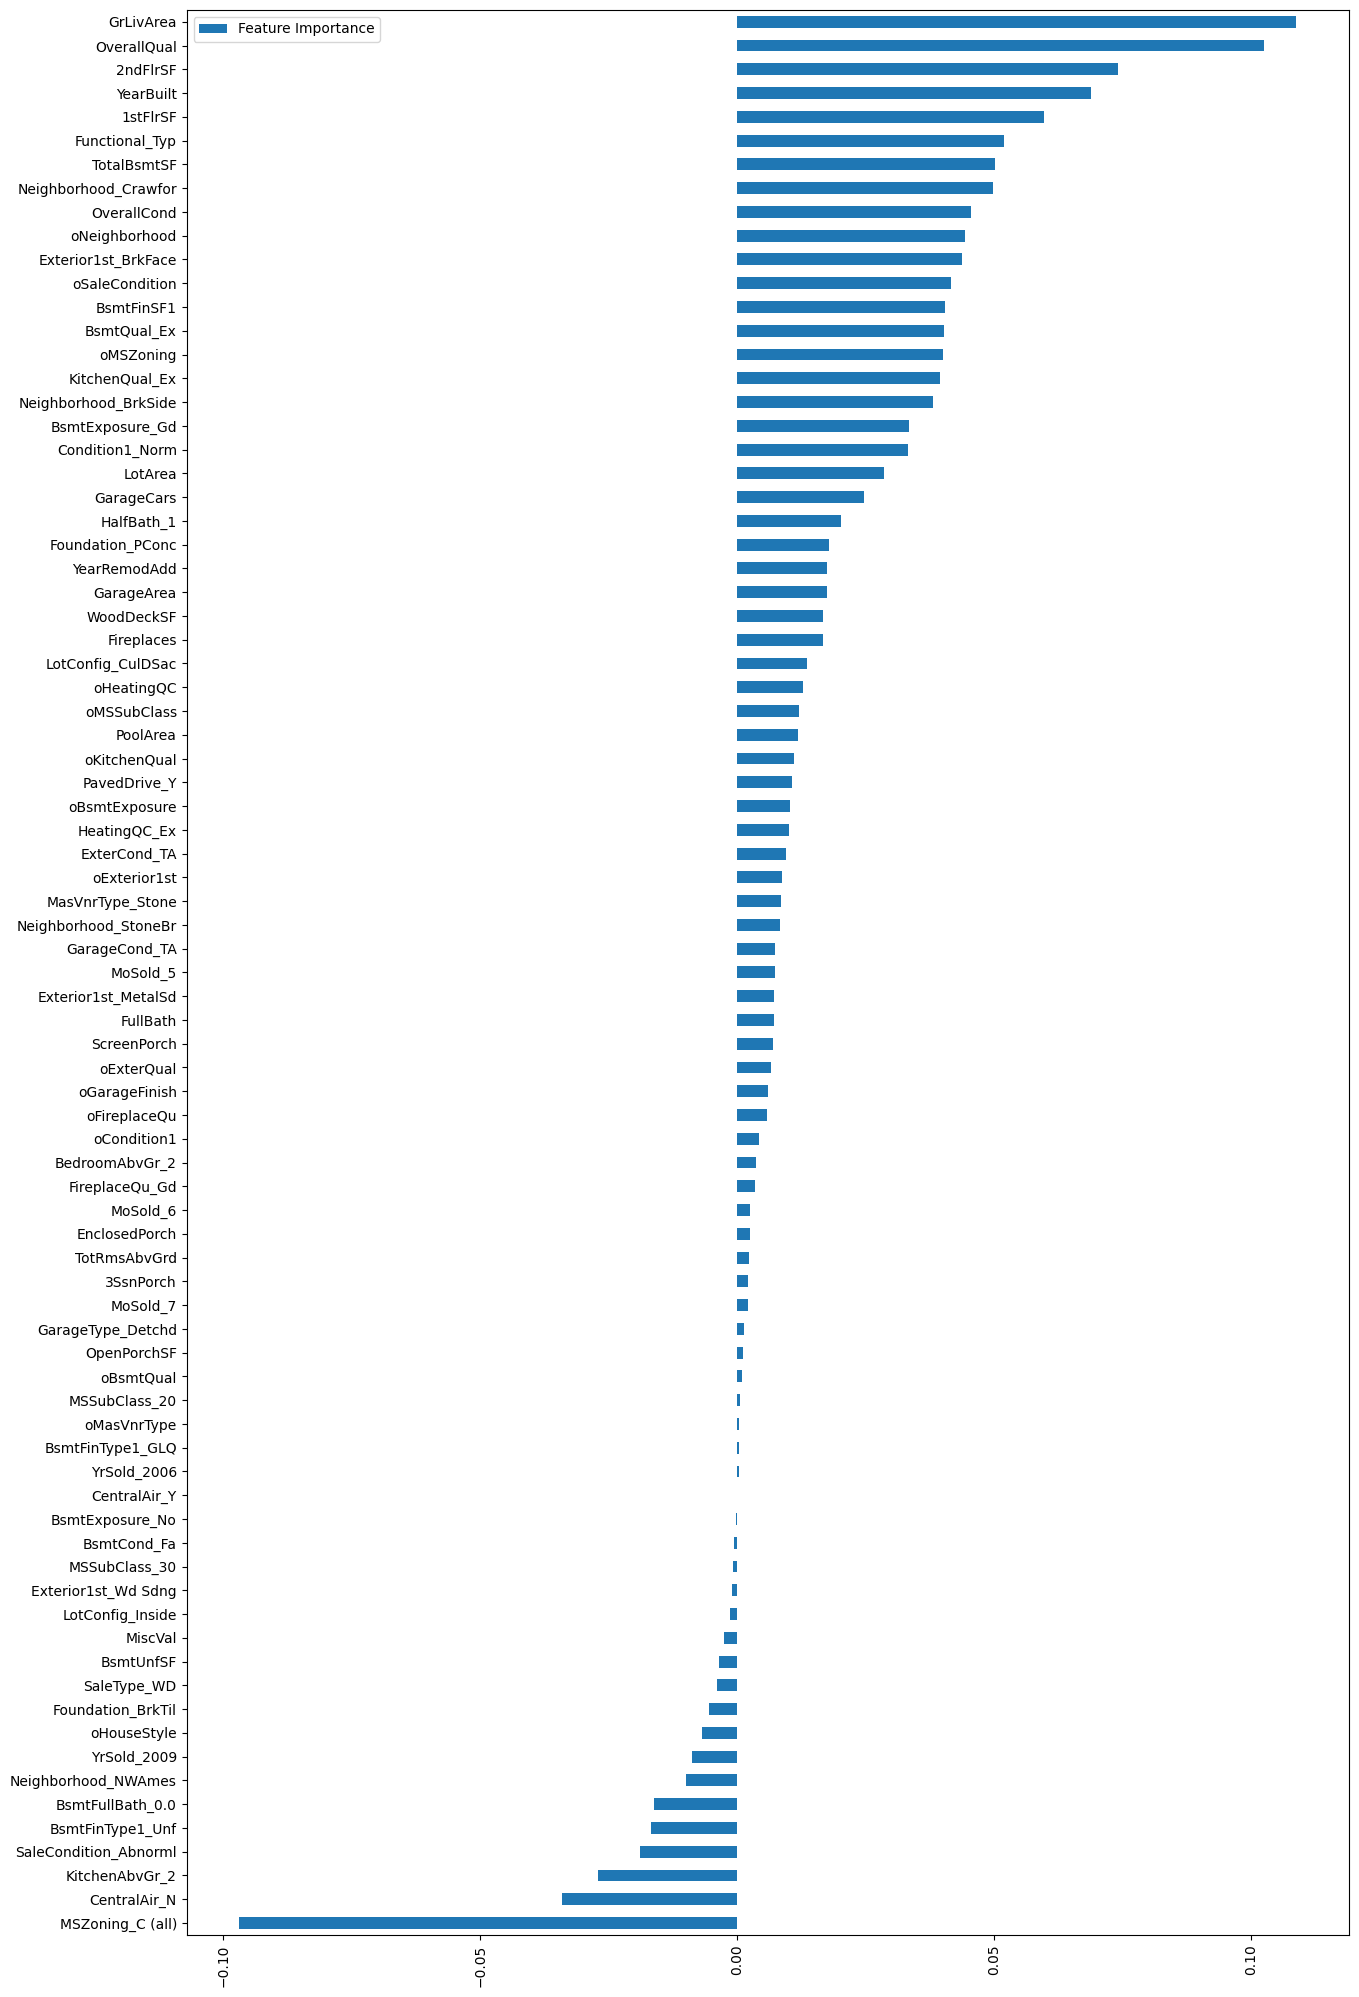

In [54]:
#将原始特征进行组合
#先用Lasso进行特征筛选，选出较重要的一些特征进行组合。
#也可以使用Ridge, RandomForest or GradientBoostingTree

lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)

FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=data_pipe.columns)
FI_lasso.sort_values("Feature Importance",ascending=False)

FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
#plt.show()

In [55]:
#最终选择加了这些特征
class added_feature(BaseEstimator, TransformerMixin):

    def fit(self,X,y=None):
        return self
    
    def transform(self,X):

            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]

            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]

            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

            return X

pipe = Pipeline([
    ('labenc', labelenc()),
    ('add_feature', added_feature()),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

print('Pipeline构建成功\n')

Pipeline构建成功



In [56]:
#PCA去除导致多重共线性的特征。
origin_pipe = pipe.fit_transform(origin)
origin_pipe.shape  #(2917, 426)
print("\nPCA去除导致多重共线性的特征\n")
n_train=train.shape[0]
X = origin_pipe[:n_train]
test_X = origin_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

pca = PCA(n_components=410)
X_scaled=pca.fit_transform(X_scaled)
test_X_scaled = pca.transform(test_X_scaled)


PCA去除导致多重共线性的特征



建模&评估(Modeling & Evaluation)

In [57]:
#定义RMSE的交叉验证评估指标：
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [58]:
models = [
        LinearRegression(),
        Ridge(),
        Lasso(alpha=0.01,max_iter=10000),
        RandomForestRegressor(),
        GradientBoostingRegressor(),
        SVR(),
        LinearSVR(),
        KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
        XGBRegressor()]

In [59]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ker", "Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 15181524820.472504, 8533522452.3680
Ridge: 0.117777, 0.0091
Lasso: 0.123686, 0.0054
RF: 0.138429, 0.0050
GBR: 0.128511, 0.0053
SVR: 0.139717, 0.0116
LinSVR: 0.119613, 0.0096
Ker: 0.109648, 0.0055
Xgb: 0.144672, 0.0047


In [60]:
# 定义一个网格搜索方法进行一些超参数调优。
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [61]:
# 超参数调优
grid(Lasso()).grid_get(X_scaled,y_log,{'alpha': [0.0004,0.0005,0.0007,0.0006,0.0009,0.0008],'max_iter':[10000]})
grid(Ridge()).grid_get(X_scaled,y_log,{'alpha':[35,40,45,50,55,60,65,70,80,90]})
grid(SVR()).grid_get(X_scaled,y_log,{'C':[11,12,13,14,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})
grid(KernelRidge()).grid_get(X_scaled,y_log,{'alpha':[0.2,0.3,0.4,0.5], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1,1.2]})


{'alpha': 0.0006, 'max_iter': 10000} 0.11065287133565983
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.111200        0.001422
1  {'alpha': 0.0005, 'max_iter': 10000}         0.110794        0.001307
2  {'alpha': 0.0007, 'max_iter': 10000}         0.110715        0.001142
3  {'alpha': 0.0006, 'max_iter': 10000}         0.110653        0.001196
4  {'alpha': 0.0009, 'max_iter': 10000}         0.110808        0.001027
5  {'alpha': 0.0008, 'max_iter': 10000}         0.110721        0.001082
{'alpha': 50} 0.11045432372664295
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.110534        0.001271
1  {'alpha': 40}         0.110488        0.001252
2  {'alpha': 45}         0.110463        0.001238
3  {'alpha': 50}         0.110454        0.001226
4  {'alpha': 55}         0.110459        0.001217
5  {'alpha': 60}         0.110474        0.001209
6  {'alpha': 65}         0.110497        0.00120

In [62]:
lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
xgb = XGBRegressor(learning_rate=0.01,n_estimators=3460,max_depth=3, min_child_weight=0,gamma=0,subsample=0.7,colsample_bytree=0.7,objective='reg:linear',nthread=-1,scale_pos_weight=1,seed=27,reg_alpha=0.00006)
rf = RandomForestRegressor(n_estimators=500,max_depth=5, min_samples_split=10,min_samples_leaf=1,max_features='sqrt',oob_score=True,random_state=10)


集成方法 (Ensemble Methods)

In [63]:
class ModelPred(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        #每个数据点，单模型预测乘以权重，然后将它们相加
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [64]:
a = SimpleImputer().fit_transform(X_scaled)
b = SimpleImputer().fit_transform(y_log.values.reshape(-1,1)).ravel()

In [65]:

weight_svr = ModelPred(mod = [svr],weight=[1])
rmse_cv(weight_svr,X_scaled,y_log),  rmse_cv(weight_svr,X_scaled,y_log).mean()

weight_svr.fit(a,b)
predweight_svr = np.exp(weight_svr.predict(test_X_scaled))
resultweight_svr=pd.DataFrame({'Id':test.Id, 'SalePrice':predweight_svr})
resultweight_svr.to_csv("submissionweight_svr.csv",index=False)



In [66]:

weight_xgb = ModelPred(mod = [xgb],weight=[1])
rmse_cv(weight_xgb,X_scaled,y_log),  rmse_cv(weight_xgb,X_scaled,y_log).mean()

weight_xgb.fit(a,b)
predweight_xgb = np.exp(weight_xgb.predict(test_X_scaled))
resultweight_xgb=pd.DataFrame({'Id':test.Id, 'SalePrice':predweight_xgb})
resultweight_xgb.to_csv("submissionweight_xgb.csv",index=False)



[21:04:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:04:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:04:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:05:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:05:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

In [67]:

weight_rf = ModelPred(mod = [rf],weight=[1])
rmse_cv(weight_rf,X_scaled,y_log),  rmse_cv(weight_rf,X_scaled,y_log).mean()

weight_rf.fit(a,b)
predweight_rf = np.exp(weight_rf.predict(test_X_scaled))
resultweight_rf=pd.DataFrame({'Id':test.Id, 'SalePrice':predweight_rf})
resultweight_rf.to_csv("submissionweight_rf.csv",index=False)



In [68]:

weight_ker = ModelPred(mod = [ker],weight=[1])
rmse_cv(weight_ker,X_scaled,y_log),  rmse_cv(weight_ker,X_scaled,y_log).mean()

weight_ker.fit(a,b)
predweight_ker = np.exp(weight_ker.predict(test_X_scaled))
resultweight_ker=pd.DataFrame({'Id':test.Id, 'SalePrice':predweight_ker})
resultweight_ker.to_csv("submissionweight_ker.csv",index=False)



In [69]:

weight_ridge = ModelPred(mod = [ridge],weight=[1])
rmse_cv(weight_ridge,X_scaled,y_log),  rmse_cv(weight_ridge,X_scaled,y_log).mean()

weight_ridge.fit(a,b)
predweight_ridge = np.exp(weight_ridge.predict(test_X_scaled))
resultweight_ridge=pd.DataFrame({'Id':test.Id, 'SalePrice':predweight_ridge})
resultweight_ridge.to_csv("submissionweight_ridge.csv",index=False)


In [70]:

weight_lasso = ModelPred(mod = [lasso],weight=[1])
rmse_cv(weight_lasso,X_scaled,y_log),  rmse_cv(weight_lasso,X_scaled,y_log).mean()

weight_lasso.fit(a,b)
predweight_lasso = np.exp(weight_lasso.predict(test_X_scaled))
resultweight_lasso=pd.DataFrame({'Id':test.Id, 'SalePrice':predweight_lasso})
resultweight_lasso.to_csv("submissionweight_lasso.csv",index=False)